# Task 1.1 [x] - Next value prediction

> Luca Laboccetta,  
> Giorgio Andronico 

## Data understanding

### Initial data collection

Boilerplate code: importing useful modules, choosing compute backend, mounting Google Drive

In [1]:
import keras
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.vis_utils import plot_model
from google.colab import drive
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt

# Choose computing backend
computing_resource = tf.test.gpu_device_name()
if "GPU" not in computing_resource:
  computing_resource = "/CPU:0"
print(f"Computing resource: {computing_resource}")

# Mount Google Drive
drive.mount('/content/drive')

# Setting seed for reproducibility
seed = 44
np.random.seed(seed)
tf.random.set_seed(seed)

     |████████████████████████████████| 135 kB 8.6 MB/s 
     |████████████████████████████████| 1.6 MB 18.0 MB/s 
Computing resource: /device:GPU:0
Mounted at /content/drive


Load *Healthware* dataset, both train and test. Loading *x* column only, as this notebook focuses only on analyzing this column

In [2]:
train = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/train.csv").drop('y', 1).drop('z', 1)
test_set = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/test.csv").drop('y', 1).drop('z', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


### Data exploration

Datasets' shapes

In [3]:
print("Train dataset shape:")
print(train.shape)
print("Test dataset shape:")
print(test_set.shape)

Train dataset shape:
(144911, 1)
Test dataset shape:
(148371, 1)


Statistical quantities for each column

In [4]:
train.describe()

,x
count,144911.000000
mean,132.732967
std,491.697810
min,-1239.000000
25%,-291.000000
50%,214.000000
75%,539.000000
max,1039.000000


Object types (this is useful to see how *pandas* parsed the .csv file)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   x       144911 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


#### Data visualization

The y-axis depicts the value of the single instance, while the x-axis is merely the row index of that instance.

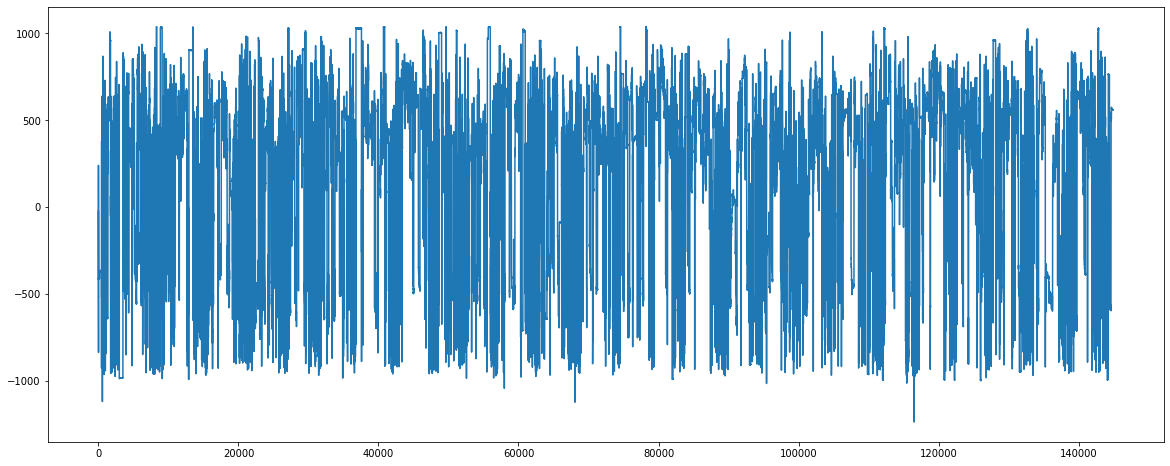

In [6]:
fig = plt.figure(figsize=(20, 8))
plt.plot(train)

## Data preparation

#### Normalization and splitting

Normalizing train data in a -1:1 range

In [7]:
mean = train.mean()
std = train.std()
train = (train - mean) / std
train

,x
0,-0.318759
1,-0.688905
2,-0.552642
3,-1.292934
4,-0.835336
...,...
144906,0.866929
144907,0.866929
144908,0.866929
144909,0.866929


Normalizing test data in a -1:1 range

In [8]:
mean = test_set.mean()
std = test_set.std()
test_set = (test_set - mean) / std
test_set

,x
0,0.743593
1,0.745321
2,0.703848
3,0.537959
4,0.524135
...,...
148366,1.414063
148367,1.414063
148368,1.414063
148369,1.414063


Creation of the validation set, extracting 30% of the training set

In [9]:
n_rows_train = round(len(train)*0.7)
train_set = train[:n_rows_train]
validation_set = train[n_rows_train:]
validation_set.index = np.arange(0, len(validation_set))
validation_set

,x
0,0.332048
1,0.315777
2,0.429668
3,0.612708
4,0.431702
...,...
43468,0.866929
43469,0.866929
43470,0.866929
43471,0.866929


#### Labeling the dataset

Defining the windowing function

In [10]:
def generate_windows(df, window_size, window_shift):
    windows = []
    labels = []

    for i in range(0, len(df), window_shift):
        if (i + window_size >= len(df)):
            break

        windows.append(df[i: i + window_size])
        labels.append(df.iloc[i + window_size])
    
    return np.array(windows, dtype=np.float32), np.array(labels, dtype=np.float32)

Windowing the dataset

In [11]:
window_size = 30
window_shift = 6

X_train, y_train = generate_windows(train_set, window_size, window_shift)
X_val, y_val = generate_windows(validation_set, window_size, window_shift)
X_test, y_test = generate_windows(test_set, window_size, window_shift)

## Modeling



### Hyperparameter search

Defining model skeleton and search ranges for each hyperparameter

In [12]:
def build_model(hp):
  model = Sequential()
  LSTM_1_units = hp.Int('LSTM_1_units', min_value=16, max_value=128, step=16)
  dropout_rate = 0.1
  model.add(LSTM(LSTM_1_units,input_shape=(window_size, X_train.shape[2])))
  model.add(Dense(1))

  lr_choices = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_choices), loss='mae')
  return model

Instantiating of the tuner on the model skeleton defined above. Definition of early stopping criteria.

In [13]:
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=50, seed=seed)
# If val_loss does not improve in five epochs straight, stop training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Searching for the best hyperparameters

In [14]:
with tf.device(computing_resource):
    tuner.search(np.array(X_train), 
                np.array(y_train), 
                validation_data=(X_val, y_val), 
                callbacks=[early_stop])

Trial 24 Complete [00h 00m 08s]
val_loss: 0.10259947925806046

Best val_loss So Far: 0.09726527333259583
Total elapsed time: 00h 04m 35s


Printing the best parameters found

In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first LSTM is {best_hps.get('LSTM_1_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first LSTM is 112.
The optimal learning rate for the optimizer is 0.001.



### Fitting and building

Building the model with the best hyperparameters found above

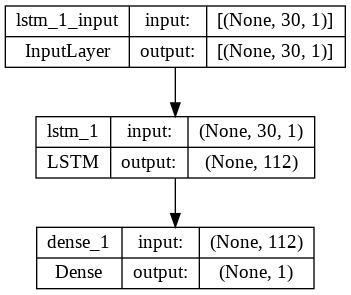

In [16]:
model = tuner.hypermodel.build(best_hps)
plot_model(model, show_shapes=True, show_layer_names=True)

Compiling and training the model on these parameters

In [17]:
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=best_hps.get('learning_rate')))
with tf.device(computing_resource):
    history = model.fit(X_train,
                        y_train, 
                        epochs=150, 
                        validation_data=(X_val, y_val))

Epoch 1/150
529/529 [==============================] - 5s 7ms/step - loss: 0.1662 - val_loss: 0.1121
Epoch 2/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1222 - val_loss: 0.1023
Epoch 3/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1178 - val_loss: 0.1004
Epoch 4/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1164 - val_loss: 0.1028
Epoch 5/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1164 - val_loss: 0.0982
Epoch 6/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1163 - val_loss: 0.1040
Epoch 7/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1161 - val_loss: 0.1012
Epoch 8/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1160 - val_loss: 0.0969
Epoch 9/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1162 - val_loss: 0.0972
Epoch 10/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1157 - val_lo

Taking the epoch where metrics have been best and re-training the model only for that number of epochs

In [18]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Epoch with lowest validation loss: {best_epoch}')

hypermodel_best_epoch = tuner.hypermodel.build(best_hps)
with tf.device(computing_resource):
    history = hypermodel_best_epoch.fit(X_train, 
                                        y_train, 
                                        epochs=best_epoch, 
                                        validation_data=(X_val, y_val))

Epoch with lowest validation loss: 8
Epoch 1/8
529/529 [==============================] - 5s 7ms/step - loss: 0.1682 - val_loss: 0.1055
Epoch 2/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1210 - val_loss: 0.1000
Epoch 3/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1179 - val_loss: 0.1001
Epoch 4/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1172 - val_loss: 0.1012
Epoch 5/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1166 - val_loss: 0.0984
Epoch 6/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1166 - val_loss: 0.1000
Epoch 7/8
529/529 [==============================] - 3s 5ms/step - loss: 0.1165 - val_loss: 0.0974
Epoch 8/8
529/529 [==============================] - 3s 6ms/step - loss: 0.1158 - val_loss: 0.0974


## Evaluation

### Metrics

The plot shows a gradual decrease in both training and validation loss, with validation steadily staying below training. No sign of overfitting. The x-axis depicts the epoch, while the y-axis depicts the loss value for that epoch.

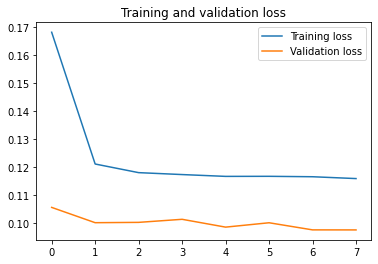

In [19]:
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predictions

Creating predictions from the test set

In [20]:
pred_test = hypermodel_best_epoch.predict(X_test)

773/773 [==============================] - 2s 2ms/step


Evaluating accuracy of the predictions

In [21]:
denormalized_predictions = (pred_test * std['x']) + mean['x']
denormalized_original_values = (y_test * std['x']) + mean['x']
mae_test = mean_absolute_error(denormalized_original_values, denormalized_predictions)
print(f'MAE for variable X: {mae_test}')

MAE for variable X: 73.57203674316406
